# This notbook was used to run the re-weight mitigation process on de-identified data and test the efficacy over different classification thresholds.

In [2]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm
import pandas as pd

from aif360.datasets import MEPSDataset19_deid
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas,\
                    load_preproc_data_adult_5att, load_preproc_data_artificial, \
                    load_preproc_data_adult_continuous, load_preproc_data_german_continuous
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from common_utils import *

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from statistics import stdev as sd, mean
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

In [4]:
# import dataset
dataset_used = "compas" #"german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        #dataset_orig = load_preproc_data_adult(['sex'])
        dataset_orig = load_preproc_data_adult_5att(['sex'])
        #dataset_orig = load_preproc_data_adult_continuous(64, ['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
        
    optim_options = {
        "distortion_fun": get_distortion_adult,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }
    
elif dataset_used == "german":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }
    
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.1,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }    

elif dataset_used == "compas":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])
        
    optim_options = {
        "distortion_fun": get_distortion_compas,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    } 
    
x = dataset_orig.convert_to_dataframe()[0]
x.head()

,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
10,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
14,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# meps19 = MEPSDataset19_deid(deid=64, age_split='28-46').convert_to_dataframe()[0]
# privileged_groups = [{'RACE': 1}]
# unprivileged_groups = [{'RACE': 0}]

# meps19.columns

In [6]:
meps21 = MEPSDataset21()
meps21

               instance weights features                                    \
                                         protected attribute                 
                                     AGE                RACE  PCS42  MCS42   
instance names                                                               
0                  12999.552725     44.0                 1.0  57.76  57.06   
1                  11361.661447     43.0                 1.0  59.11  54.10   
2                  13263.220829     16.0                 1.0  -1.00  -1.00   
3                  11616.068609     13.0                 1.0  -1.00  -1.00   
4                   4446.485068     66.0                 0.0  22.45  53.13   
...                         ...      ...                 ...    ...    ...   
17046               9699.333659     45.0                 0.0  29.68  59.35   
17048              10294.600896     16.0                 0.0  -1.00  -1.00   
17049               4905.602112     34.0                 0.0  51

In [ ]:
class_thresh_arr = [0.01, 0.01989899, 0.02979798, 0.03969697, 0.04959596,
       0.05949495, 0.06939394, 0.07929293, 0.08919192, 0.09909091,
       0.1089899 , 0.11888889, 0.12878788, 0.13868687, 0.14858586,
       0.15848485, 0.16838384, 0.17828283, 0.18818182, 0.19808081,
       0.2079798 , 0.21787879, 0.22777778, 0.23767677, 0.24757576,
       0.25747475, 0.26737374, 0.27727273, 0.28717172, 0.29707071,
       0.3069697 , 0.31686869, 0.32676768, 0.33666667, 0.34656566,
       0.35646465, 0.36636364, 0.37626263, 0.38616162, 0.39606061,
       0.4059596 , 0.41585859, 0.42575758, 0.43565657, 0.44555556,
       0.45545455, 0.46535354, 0.47525253, 0.48515152, 0.49505051,
       0.50494949, 0.51484848, 0.52474747, 0.53464646, 0.54454545,
       0.55444444, 0.56434343, 0.57424242, 0.58414141, 0.5940404 ,
       0.60393939, 0.61383838, 0.62373737, 0.63363636, 0.64353535,
       0.65343434, 0.66333333, 0.67323232, 0.68313131, 0.6930303 ,
       0.70292929, 0.71282828, 0.72272727, 0.73262626, 0.74252525,
       0.75242424, 0.76232323, 0.77222222, 0.78212121, 0.7920202 ,
       0.80191919, 0.81181818, 0.82171717, 0.83161616, 0.84151515,
       0.85141414, 0.86131313, 0.87121212, 0.88111111, 0.8910101 ,
       0.90090909, 0.91080808, 0.92070707, 0.93060606, 0.94050505,
       0.95040404, 0.96030303, 0.97020202, 0.98010101, 0.99]
# AC, BA, SP, DI, PP, PP_P, PP_U, FN, FN_p, fn_u, tp_p, tp_u, tp, tp_r
# AC, BA, SP, DI, PP, PP_P, PP_U, FN, FN_p, fn_u, tp_p, tp_u, tp, tp_r

In [8]:
meps21.convert_to_dataframe(de_dummy_code=True)[0]

,AGE,RACE,PCS42,MCS42,K6SUM42,UTILIZATION,REGION,SEX,MARRY,FTSTU,...,ACTLIM,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV
0,44.0,White,57.76,57.06,1.0,>= 10 Visits,1,2,1,-1,...,2,2,2,2,2,2,0,1,5,1
1,43.0,White,59.11,54.10,3.0,< 10 Visits,1,1,1,-1,...,2,2,2,2,2,2,0,1,5,1
2,16.0,White,-1.00,-1.00,-1.0,< 10 Visits,1,1,5,-1,...,2,2,-1,2,2,-1,-1,1,5,1
3,13.0,White,-1.00,-1.00,-1.0,< 10 Visits,1,1,6,-1,...,2,2,-1,2,2,-1,-1,-1,5,1
4,66.0,Non-White,22.45,53.13,0.0,>= 10 Visits,1,1,3,-1,...,1,1,1,2,1,1,0,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17046,45.0,Non-White,29.68,59.35,0.0,>= 10 Visits,3,2,1,-1,...,2,2,2,2,2,2,0,1,5,1
17048,16.0,Non-White,-1.00,-1.00,-1.0,< 10 Visits,3,1,5,-1,...,2,2,-1,2,2,-1,-1,4,5,1
17049,34.0,Non-White,51.55,55.53,3.0,< 10 Visits,4,1,1,-1,...,2,2,2,2,2,2,0,4,3,1
17050,29.0,Non-White,57.49,54.20,2.0,< 10 Visits,4,2,1,-1,...,2,2,2,2,2,2,0,4,3,3


In [9]:
# meps19['sum'] = meps19.apply(lambda x: sum(x[meps19.iloc[:, 10:20].columns]), axis=1)
# meps19['sum'].unique()

In [10]:
# dataset_orig = load_preproc_data_german_continuous(1, '43-43', ['sex'])

In [11]:
seeds = [40146, 20613, 8530, 42664,  2585,  8930, 29868, 22414, 7658, 2022]
iters = len(seeds)
names = 'ORIG_AC,TRANSF_AC,ORIG_BA,TRANSF_BA,ORIG_SP,TRANSF_SP,ORIG_DI,TRANSF_DI,orig_PP, trans_PP, orig_FN, trans_FN'

# mean_list = []
# sd_list = []
# metric_list = [[[] for _ in range(100)] for _ in range(36)]
# for seed in seeds:
#     print(seed)
#     metrics = run_full_process(dataset_orig, privileged_groups, unprivileged_groups, optim_options, miti_method='reweight', seed=seed)
#     #print(metrics)
#     for i in range(len(metrics)):
#         for j in range(len(metrics[i])):
#             metric_list[i][j].append(metrics[i][j])
    
# for i in metric_list:
#     means = []
#     sds = []
#     for j in i:
#         means.append(round(mean(j), 4))
#         sds.append(round(sd(j), 4))
#     mean_list.append(means)
#     sd_list.append(sds)

# print(mean_list)
# print(sd_list)

dif_lev_metrics = [[1],[2],[4],[6],[8],[10],[12],[14],[16],[32],[64],[128],[256]]

lev_list = [1,2,4,6,8,10,12,14,16,32,64,128,256]
split = ['43-43', '40-39', '40-30', '37-22', '32-20', '31-17', '30-14', '27-14', '24-13', '11-7', '8-3', '4-2', '2-1']
split = ['86-86', '86-86', '86-86', '85-86', '83-85', '84-83', '81-83', '75-81', '73-79', '53-67', '28-46', '18-31', '6-12', '2-1']
for lev in range(len(lev_list)):
    metric_list = [[] for _ in range(32)]
    race_gen_list = [[] for _ in range(8)]
    mean_list = []
    sd_list = []
    dataset_orig = MEPSDataset19_deid(lev_list[lev], split[lev])
    #print(dataset_orig)
    for seed in seeds:
        print(seed)
        
        metrics = run_full_process(dataset_orig, privileged_groups, unprivileged_groups, optim_options, miti_method='reweight', seed=seed)
        for i in range(len(metrics)):
            metric_list[i].append(metrics[i])
        
#         for i in range(len(race_gen)):
#             race_gen_list[i].append(metrics[i])


    for i in metric_list:
        mean_list.append(round(mean(i), 4))
        sd_list.append(round(sd(i), 4))

    dif_lev_metrics[lev] += mean_list
    dif_lev_metrics[lev] += sd_list
    
print(dif_lev_metrics)

40146
20613
8530
42664
2585
8930
29868
22414
7658
2022
[[0.3029, 0.3442, 0.3892, 0.4045, 0.449, 0.4699, 0.4843, 0.5488, 0.565, 0.5763, 0.5899, 0.6127, 0.6196, 0.6326, 0.641, 0.6486, 0.6565, 0.6619, 0.6634, 0.6677, 0.6793, 0.7186, 0.7275, 0.7294, 0.7353, 0.7385, 0.7394, 0.7403, 0.7433, 0.748, 0.7669, 0.7743, 0.7754, 0.7763, 0.7819, 0.7877, 0.7897, 0.7907, 0.7926, 0.7946, 0.7955, 0.7988, 0.7989, 0.7993, 0.8002, 0.8008, 0.8015, 0.8023, 0.8027, 0.803, 0.8033, 0.8032, 0.8034, 0.8033, 0.8032, 0.8032, 0.8031, 0.8021, 0.7988, 0.795, 0.7949, 0.7945, 0.7936, 0.792, 0.7918, 0.7918, 0.7918, 0.7918, 0.7893, 0.7764, 0.7732, 0.7732, 0.7732, 0.7688, 0.7624, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609, 0.7609], [0.344, 0.3596, 0.3689, 0.3798, 0.4288, 0.4522, 0.4631, 0.5101, 0.5215, 0.5348, 0.5462, 0.5516, 0.5574, 0.5597, 0.5683, 0.5774, 0.5803, 0.5852, 0.586

In [24]:
#print(len(dif_lev_metrics[0]))
mx = pd.read_csv('/home/andrew/Desktop/Test_Files/csv_outputs/metrics_header.csv')
mets = pd.DataFrame(dif_lev_metrics, columns=mx.columns)
mx = mx.append(mets)
# mx.to_csv('/home/andrew/Desktop/Test_Files/csv_outputs/MEPS_kanon[sex+age]_reweight_TP_SD.csv', index=False)
# mx = mx.iloc[:,:30]
mx['O_ACC', 'O_DI', ]

,Deid,O_ACC,OAC_P,OAC_U,O_BA,O_SP,O_DI,OPP,OPP_P,OPP_U,...,TPP_sd,TPP_P_sd,TPP_U_sd,TFN_sd,TFN_P_sd,TFN_U_sd,TTP_sd,TTP_P_sd,TTP_U_sd,TTP_Ratio_sd
0,1,0.7923,0.6996,0.8438,0.7742,-0.2651,0.4258,0.2914,0.4619,0.1967,...,0.0267,0.0360,0.0247,0.0415,0.0515,0.0349,0.0415,0.0515,0.0349,0.0477
1,2,0.7811,0.6842,0.8351,0.7704,-0.2729,0.4311,0.3050,0.4804,0.2076,...,0.0346,0.0395,0.0342,0.0430,0.0526,0.0364,0.0430,0.0526,0.0364,0.0460
2,4,0.7901,0.6967,0.8422,0.7719,-0.2659,0.4262,0.2927,0.4636,0.1978,...,0.0292,0.0385,0.0264,0.0418,0.0549,0.0341,0.0418,0.0549,0.0341,0.0592
3,6,0.7841,0.6865,0.8383,0.7733,-0.2732,0.4294,0.3029,0.4786,0.2054,...,0.0220,0.0295,0.0214,0.0312,0.0396,0.0358,0.0312,0.0396,0.0358,0.0580
4,8,0.7850,0.6899,0.8378,0.7724,-0.2687,0.4324,0.3010,0.4737,0.2051,...,0.0293,0.0335,0.0296,0.0402,0.0490,0.0371,0.0402,0.0490,0.0371,0.0500
5,10,0.7833,0.6883,0.8360,0.7717,-0.2682,0.4346,0.3028,0.4753,0.2071,...,0.0379,0.0469,0.0349,0.0501,0.0634,0.0398,0.0501,0.0634,0.0398,0.0559
6,12,0.7906,0.6976,0.8423,0.7715,-0.2648,0.4263,0.2917,0.4621,0.1972,...,0.0301,0.0387,0.0279,0.0444,0.0563,0.0366,0.0444,0.0563,0.0366,0.0552
7,14,0.7808,0.6834,0.8349,0.7722,-0.2741,0.4324,0.3070,0.4833,0.2092,...,0.0282,0.0337,0.0283,0.0438,0.0519,0.0421,0.0438,0.0519,0.0421,0.0531
8,16,0.7887,0.6944,0.8411,0.7732,-0.2680,0.4270,0.2959,0.4683,0.2002,...,0.0283,0.0350,0.0274,0.0459,0.0531,0.0440,0.0459,0.0531,0.0440,0.0509
9,32,0.7883,0.6908,0.8425,0.7704,-0.2721,0.4195,0.2942,0.4692,0.1971,...,0.0310,0.0381,0.0302,0.0449,0.0565,0.0377,0.0449,0.0565,0.0377,0.0575


In [11]:
mx = pd.read_csv('/home/andrew/Desktop/Test_Files/csv_outputs/adult_kanon_reweight_5att_TP_SD.csv')

mx2 = mx[['O_ACC','T_ACC','O_DI','T_DI','OPP_P','TPP_P','OPP_U','TPP_U','O_ACC','T_ACC','OTP_Ratio','TTP_Ratio','OPP', 'TPP','OTP','TTP']]
mx2

,O_ACC,T_ACC,O_DI,T_DI,OPP_P,TPP_P,OPP_U,TPP_U,O_ACC,T_ACC,OTP_Ratio,TTP_Ratio,OPP,TPP,OTP,TTP
0,0.6950,0.6604,0.2541,0.8682,0.5904,0.4853,0.1503,0.4215,0.6950,0.6604,0.4830,0.9971,0.4455,0.4644,0.7940,0.7610
1,0.7010,0.6713,0.2735,0.8229,0.5790,0.4790,0.1586,0.3943,0.7010,0.6713,0.5471,0.9641,0.4406,0.4511,0.7963,0.7561
2,0.7007,0.6709,0.2731,0.8204,0.5799,0.4805,0.1586,0.3943,0.7007,0.6709,0.5468,0.9621,0.4412,0.4522,0.7968,0.7575
3,0.7038,0.6730,0.2702,0.8203,0.5725,0.4756,0.1550,0.3902,0.7038,0.6730,0.5409,0.9649,0.4351,0.4475,0.7907,0.7521
4,0.7018,0.6719,0.2726,0.8197,0.5774,0.4789,0.1576,0.3927,0.7018,0.6719,0.5444,0.9626,0.4392,0.4505,0.7950,0.7561
5,0.7014,0.6718,0.2726,0.8209,0.5784,0.4786,0.1578,0.3929,0.7014,0.6718,0.5443,0.9625,0.4400,0.4504,0.7958,0.7557
6,0.6986,0.6689,0.2757,0.8266,0.5843,0.4829,0.1613,0.3993,0.6986,0.6689,0.5471,0.9677,0.4451,0.4554,0.8007,0.7599
7,0.7018,0.6719,0.2681,0.8303,0.5770,0.4756,0.1550,0.3952,0.7018,0.6719,0.5316,0.9640,0.4381,0.4491,0.7927,0.7532
8,0.6997,0.6705,0.2717,0.8314,0.5820,0.4788,0.1583,0.3982,0.6997,0.6705,0.5404,0.9621,0.4425,0.4523,0.7977,0.7569
9,0.7026,0.6718,0.2638,0.8285,0.5753,0.4744,0.1524,0.3934,0.7026,0.6718,0.5200,0.9596,0.4361,0.4478,0.7900,0.7500


,O_ACC,T_ACC,O_DI,T_DI,OPP_P,TPP_P,OPP_U,TPP_U,O_ACC,T_ACC,OTP_Ratio,TTP_Ratio,OPP,TPP,OTP,TTP
0,0.6950,0.6604,0.2541,0.8682,0.5904,0.4853,0.1503,0.4215,0.6950,0.6604,0.4830,0.9971,0.4455,0.4644,0.7940,0.7610
1,0.7010,0.6713,0.2735,0.8229,0.5790,0.4790,0.1586,0.3943,0.7010,0.6713,0.5471,0.9641,0.4406,0.4511,0.7963,0.7561
2,0.7007,0.6709,0.2731,0.8204,0.5799,0.4805,0.1586,0.3943,0.7007,0.6709,0.5468,0.9621,0.4412,0.4522,0.7968,0.7575
3,0.7038,0.6730,0.2702,0.8203,0.5725,0.4756,0.1550,0.3902,0.7038,0.6730,0.5409,0.9649,0.4351,0.4475,0.7907,0.7521
4,0.7018,0.6719,0.2726,0.8197,0.5774,0.4789,0.1576,0.3927,0.7018,0.6719,0.5444,0.9626,0.4392,0.4505,0.7950,0.7561
5,0.7014,0.6718,0.2726,0.8209,0.5784,0.4786,0.1578,0.3929,0.7014,0.6718,0.5443,0.9625,0.4400,0.4504,0.7958,0.7557
6,0.6986,0.6689,0.2757,0.8266,0.5843,0.4829,0.1613,0.3993,0.6986,0.6689,0.5471,0.9677,0.4451,0.4554,0.8007,0.7599
7,0.7018,0.6719,0.2681,0.8303,0.5770,0.4756,0.1550,0.3952,0.7018,0.6719,0.5316,0.9640,0.4381,0.4491,0.7927,0.7532
8,0.6997,0.6705,0.2717,0.8314,0.5820,0.4788,0.1583,0.3982,0.6997,0.6705,0.5404,0.9621,0.4425,0.4523,0.7977,0.7569
9,0.7026,0.6718,0.2638,0.8285,0.5753,0.4744,0.1524,0.3934,0.7026,0.6718,0.5200,0.9596,0.4361,0.4478,0.7900,0.7500


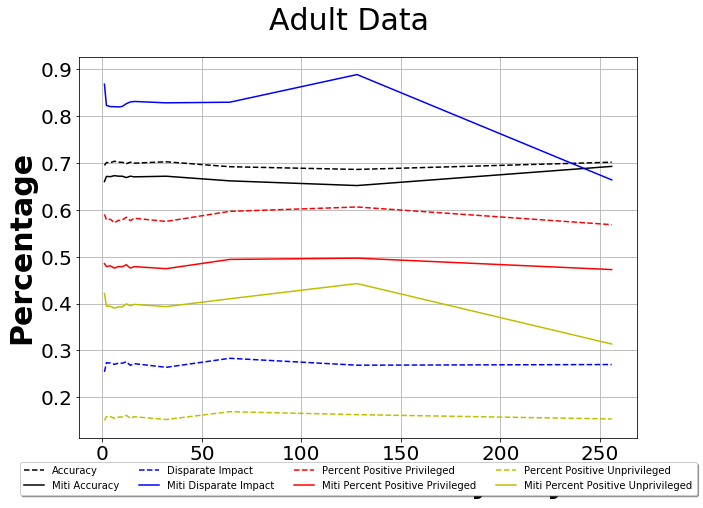

In [25]:
fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('Adult Data', fontsize='30')
ax1.set_xlabel('De-identification: $k$-anonymity Level', fontsize=30, fontweight='bold')
ax1.set_ylabel('Percentage', color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.grid(True)

ax1.plot(mx['Deid'], mx['O_ACC'], '--', color='k', label='Accuracy')
ax1.plot(mx['Deid'], mx['T_ACC'], color='k', label='Miti Accuracy')

ax1.plot(mx['Deid'], mx['O_DI'], '--', color='b', label='Disparate Impact')
ax1.plot(mx['Deid'], mx['T_DI'], color='b', label='Miti Disparate Impact')

ax1.plot(mx['Deid'], mx['OPP_P'], '--', color='r', label='Percent Positive Privileged')
ax1.plot(mx['Deid'], mx['TPP_P'], color='r', label='Miti Percent Positive Privileged')

ax1.plot(mx['Deid'], mx['OPP_U'], '--', color='y', label='Percent Positive Unprivileged')
ax1.plot(mx['Deid'], mx['TPP_U'], color='y', label='Miti Percent Positive Unprivileged')


#legend = plt.legend(loc=1, prop={'size': 12}, ncol=1, framealpha=1, shadow=True, borderpad=1)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

file_loc = '/home/andrew/Desktop/Test_Files/Plots/'
file_name = 'Adult_ACC' + '_DI_PP' + '.png'
destination = file_loc + file_name
# plt.savefig(destination)

mx2 = mx[['O_ACC','T_ACC','O_DI','T_DI','OPP_P','TPP_P','OPP_U','TPP_U','O_ACC','T_ACC','OTP_Ratio','TTP_Ratio','OPP', 'TPP','OTP','TTP']]
mx2

,O_ACC,T_ACC,O_DI,T_DI,OPP_P,TPP_P,OPP_U,TPP_U,O_ACC,T_ACC,OTP_Ratio,TTP_Ratio,OPP,TPP,OTP,TTP
0,0.6950,0.6604,0.2541,0.8682,0.5904,0.4853,0.1503,0.4215,0.6950,0.6604,0.4830,0.9971,0.4455,0.4644,0.7940,0.7610
1,0.7010,0.6713,0.2735,0.8229,0.5790,0.4790,0.1586,0.3943,0.7010,0.6713,0.5471,0.9641,0.4406,0.4511,0.7963,0.7561
2,0.7007,0.6709,0.2731,0.8204,0.5799,0.4805,0.1586,0.3943,0.7007,0.6709,0.5468,0.9621,0.4412,0.4522,0.7968,0.7575
3,0.7038,0.6730,0.2702,0.8203,0.5725,0.4756,0.1550,0.3902,0.7038,0.6730,0.5409,0.9649,0.4351,0.4475,0.7907,0.7521
4,0.7018,0.6719,0.2726,0.8197,0.5774,0.4789,0.1576,0.3927,0.7018,0.6719,0.5444,0.9626,0.4392,0.4505,0.7950,0.7561
5,0.7014,0.6718,0.2726,0.8209,0.5784,0.4786,0.1578,0.3929,0.7014,0.6718,0.5443,0.9625,0.4400,0.4504,0.7958,0.7557
6,0.6986,0.6689,0.2757,0.8266,0.5843,0.4829,0.1613,0.3993,0.6986,0.6689,0.5471,0.9677,0.4451,0.4554,0.8007,0.7599
7,0.7018,0.6719,0.2681,0.8303,0.5770,0.4756,0.1550,0.3952,0.7018,0.6719,0.5316,0.9640,0.4381,0.4491,0.7927,0.7532
8,0.6997,0.6705,0.2717,0.8314,0.5820,0.4788,0.1583,0.3982,0.6997,0.6705,0.5404,0.9621,0.4425,0.4523,0.7977,0.7569
9,0.7026,0.6718,0.2638,0.8285,0.5753,0.4744,0.1524,0.3934,0.7026,0.6718,0.5200,0.9596,0.4361,0.4478,0.7900,0.7500


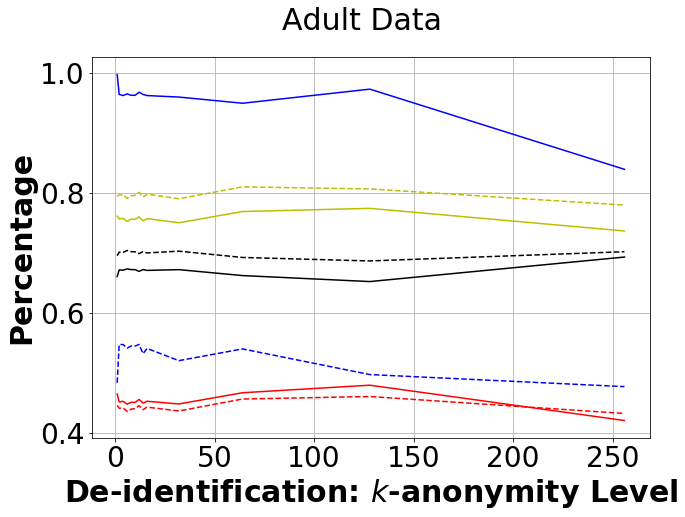

In [26]:
fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('Adult Data', fontsize='30')
ax1.set_xlabel('De-identification: $k$-anonymity Level', fontsize=30, fontweight='bold')
ax1.set_ylabel('Percentage', color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=28)
ax1.yaxis.set_tick_params(labelsize=28)
ax1.grid(True)

ax1.plot(mx['Deid'], mx['O_ACC'], '--', color='k', label='Accuracy')
ax1.plot(mx['Deid'], mx['T_ACC'], color='k', label='Miti Accuracy')

ax1.plot(mx['Deid'], mx['OTP_Ratio'], '--', color='b', label='TP Ratio')
ax1.plot(mx['Deid'], mx['TTP_Ratio'], color='b', label='Miti TP ratio')

ax1.plot(mx['Deid'], mx['OPP'], '--', color='r', label='Percent Positive Overall')
ax1.plot(mx['Deid'], mx['TPP'], color='r', label='Miti Percent Positive Overall')

ax1.plot(mx['Deid'], mx['OTP'], '--', color='y', label='TP Rate (Recall)')
ax1.plot(mx['Deid'], mx['TTP'], color='y', label='Miti TP Rate (Recall)')


# ax1.plot(mx['Deid'], mx['OTP_P'], '--', color='b', marker='|')
# ax1.plot(mx['Deid'], mx['OTP_U'], '--', color='c', marker='|')


# ax1.plot(mx['Deid'], mx['TTP_P'], color='b', marker='|')
# ax1.plot(mx['Deid'], mx['TTP_U'], color='c', marker='|')

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

file_loc = '/home/andrew/Desktop/Test_Files/Plots/'
file_name = 'Adult_PP' + '_TP_rat' + '.png'
destination = file_loc + file_name
# plt.savefig(destination)

mx2 = mx[['O_ACC','T_ACC','O_DI','T_DI','OPP_P','TPP_P','OPP_U','TPP_U','O_ACC','T_ACC','OTP_Ratio','TTP_Ratio','OPP', 'TPP','OTP','TTP']]
mx2

In [28]:
met_list = []
for met in mean_list:
    met_list.append(met[28])
print(met_list)

[0.7433, 0.6848, 0.8627, 0.7409, -0.3963, 0.2076, 0.3696, 0.5001, 0.1038, 0.2638, 0.1958, 0.6554, 0.7362, 0.8042, 0.3446, 0.4289, 0.7554, 0.7449, 0.777, 0.7088, -0.0763, 0.7665, 0.3017, 0.3269, 0.2505, 0.3805, 0.382, 0.3719, 0.6195, 0.618, 0.6281, 1.0165]


In [12]:
best_ct_miti = mean_list[21].index(max(mean_list[21]))/100
best_ct = mean_list[3].index(max(mean_list[3]))/100
print(best_ct, best_ct_miti)

0.23 0.21


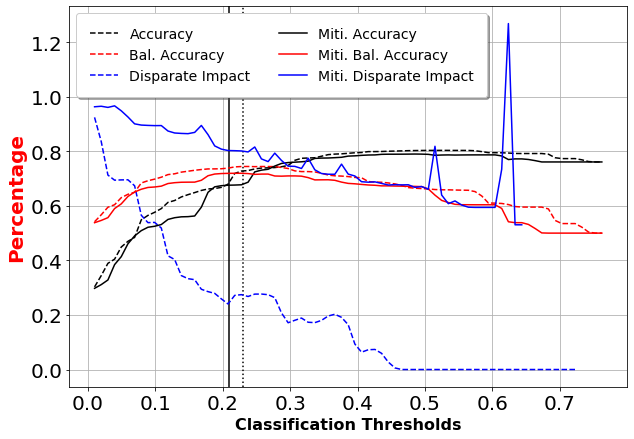

In [38]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage', color='r', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.axvline(best_ct, color='k', linestyle=':')
ax1.axvline(best_ct_miti, color='k')
ax1.grid(True)

ax1.plot(class_thresh_arr, mean_list[0], '--', color='k', label='Accuracy')
ax1.plot(class_thresh_arr, mean_list[3], '--', color='r', label='Bal. Accuracy')
ax1.plot(class_thresh_arr, mean_list[5], '--', color='b', label='Disparate Impact')
ax1.plot(class_thresh_arr, mean_list[18], color='k', label='Miti. Accuracy')

ax1.plot(class_thresh_arr, mean_list[21], color='r', label='Miti. Bal. Accuracy')

# ax1.plot(class_thresh_arr, mean_list[6], color='b', label='Positive Percentage')
# ax1.plot(class_thresh_arr, mean_list[12], color='y', label='True Positive Rate')
# ax1.plot(class_thresh_arr, mean_list[15], '--', color='y', label='True Positive Differential')

ax1.plot(class_thresh_arr, mean_list[23], color='b', label='Miti. Disparate Impact')
# ax1.plot(class_thresh_arr, mean_list[22], color='b', label='Miti. Positive Percentage')
# ax1.plot(class_thresh_arr, mean_list[28], color='y', label='Miti. True Positive Rate')
# ax1.plot(class_thresh_arr, mean_list[31], '--', color='y', label='True Positive Differential')


legend = plt.legend(loc=2, prop={'size': 14}, ncol=2, framealpha=1, shadow=True, borderpad=1)

file_loc = '/home/andrew/Desktop/Test_Files/Plots/'
file_name = 'threshold_accu' + '.png'
destination = file_loc + file_name
plt.savefig(destination)

In [20]:
ct_list = []
for i in range(len(mean_list)):
    ct_list.append(mean_list[i][int(best_ct*100)])
    
ct_miti_list = []
for i in range(len(mean_list)):
    ct_miti_list.append(mean_list[i][int(best_ct_miti*100)])

In [21]:
print(ct_list[:18])
print()
print(ct_miti_list[18:])

[0.7294, 0.67, 0.8503, 0.7443, -0.3871, 0.2677, 0.4011, 0.5286, 0.1414, 0.2271, 0.1731, 0.5387, 0.7729, 0.8269, 0.4613, 0.5578, 0.4607, 0.7729]

[0.6762, 0.6842, 0.6599, 0.7194, -0.0991, 0.8022, 0.4683, 0.5009, 0.4018, 0.1979, 0.1953, 0.2123, 0.8021, 0.8047, 0.7877, 0.979, 0.4096, 0.8021]


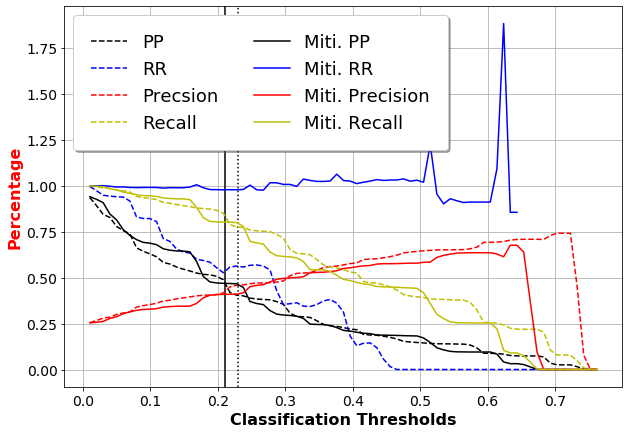

In [33]:
class_thresh_arr = class_thresh_arr[:77]
for i in range(len(mean_list)):
    mean_list[i] = mean_list[i][:77]

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.axvline(best_ct, color='k', linestyle=':')
ax1.axvline(best_ct_miti, color='k')


ax1.grid(True)

# ax1.plot(class_thresh_arr, mean_list[0], '--', color='k', label='Accuracy')
# ax1.plot(class_thresh_arr, mean_list[18], color='k', label='Miti. Accuracy')

# ax1.plot(class_thresh_arr, mean_list[3], '--', color='k', label='Balanced Accuracy')
# ax1.plot(class_thresh_arr, mean_list[21], color='k', label='Miti. Balanced Accuracy')

ax1.plot(class_thresh_arr, mean_list[6], '--', color='k', label='PP')


# ax1.plot(class_thresh_arr, mean_list[12], '--', color='g', label='Recall')
# ax1.plot(class_thresh_arr, mean_list[30], color='g', label='Miti. Recall')

ax1.plot(class_thresh_arr, mean_list[15], '--', color='b', label='RR')
ax1.plot(class_thresh_arr, mean_list[16], '--', color='r', label='Precsion')
ax1.plot(class_thresh_arr, mean_list[17], '--', color='y', label='Recall')
ax1.plot(class_thresh_arr, mean_list[24], color='k', label='Miti. PP')
ax1.plot(class_thresh_arr, mean_list[33], color='b', label='Miti. RR')

# ax1.plot(class_thresh_arr, mean_list[13], '--', color='r', label='True Positive Priv')
# ax1.plot(class_thresh_arr, mean_list[31], color='r', label='True Positive Unpriv')

# ax1.plot(class_thresh_arr, mean_list[14], '--', color='y', label='True Positive Differential')
# ax1.plot(class_thresh_arr, mean_list[32], color='y', label='True Positive Differential')


ax1.plot(class_thresh_arr, mean_list[34], color='r', label='Miti. Precision')


ax1.plot(class_thresh_arr, mean_list[35], color='y', label='Miti. Recall')

legend = plt.legend(loc=2, prop={'size': 18}, ncol=2, framealpha=1, shadow=True, borderpad=1)

file_loc = '/home/andrew/Desktop/Test_Files/Plots/'
file_name = 'threshold_utility'+'.png'
destination = file_loc + file_name
plt.savefig(destination)

In [ ]:
# file_loc = '/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/artificial/TESTY/'
# imb = [1]#, 2, 1]
# #priv_pos = [50]#, 40, 20, 10, 5]
# #unpr_pos = [1]#[40]#, 20, 10, 5, 1]
# #dif_og = ['50_40', '50_20', '50_10', '50_5', '50_1', '40_20', '40_10', '40_5', '40_1', '20_10', '20_5', '20_1', '10_5', '10_1', '5_1']
# dif = ['40_20']#, '50_20', '50_10', '50_5', '40_20', '40_10', '40_5', '20_10', '20_5', '10_5']
# deid_lev = ['og']#, 'deid4', 'deid8', 'deid16']
# seeds = [7006, 3386, 5245, 4175, 1667, 3032, 6839, 7262, 3024, 2991]
# iters = len(seeds)
# names = 'ORIG_AC, TRANSF_AC, ORIG_BA, TRANSF_BA, ORIG_SP, \
# TRANSF_SP, ORIG_DI, TRANSF_DI, orig_PP, trans_PP, orig_FN, trans_FN'


# rows_for_df = []

# for i in imb:
#     for f in dif:
#         for d in deid_lev:
#             file_path = file_loc + str(i)  + '_' + f + '_' + str(d)
#             data_info = [i, f.split('_')[0], f.split('_')[1], d]
#             #print(file_path)
#             dataset_orig = load_preproc_data_artificial(file_path, ['sex'])
            
#             metric_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#             final_mets = []
#             for seed in seeds:
#                 np.random.seed(seed)
#                 metrics = run_full_process(dataset_orig, privileged_groups, unprivileged_groups, optim_options, miti_method='reweight', seed=seed)
#                 for j in range(len(metrics)):
#                     metric_list[j] += metrics[j]

#             for met in metric_list:
#                 met/=iters
#                 met = round(met, 5)
#                 final_mets.append(met)
#             complete_row = data_info + final_mets
#             rows_for_df.append(complete_row)
                
# print(rows_for_df)

In [1]:
# Training pos percentage = 0.248
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.grid(True)
ax1.axvline(.248, color='k', linestyle=':')

ax1.plot(class_thresh_arr, mean_list[0], color='r')
ax1.plot(class_thresh_arr, mean_list[1], '--', color='r')
# ax1.plot(class_thresh_arr, mean_list[4], color='b')
# ax1.plot(class_thresh_arr, mean_list[3], '--', color='b')
ax1.plot(class_thresh_arr, mean_list[13], color='y')
ax1.plot(class_thresh_arr, mean_list[12], '--', color='y')

file_loc = '/home/andrew/Desktop/Test_Files/Plots/'
file_name = 'Plot_accu_' + 'tp' + '.png'
destination = file_loc + file_name
plt.savefig(destination)

NameError: name 'plt' is not defined

In [ ]:
matrix = pd.read_csv('/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/MITIGATION RESULTS/Deid_OPTPREPROC_8000_Results_P+U.csv')
matrix = matrix.append(pd.DataFrame(rows_for_df, columns=matrix.columns), ignore_index=True)
matrix.to_csv('/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/MITIGATION RESULTS/Deid_OPTPREPROC_8000_Results_P+U.csv', index=False)
matrix

In [ ]:
matrix = pd.read_csv('/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/MITIGATION RESULTS/Deid_Miti_8000_Results.csv')
matrix

In [ ]:
sdf

In [ ]:
len(all_list[4])

c = []
x = all_list[0]
for i in all_list:
    for j in x:
        if j in i:
            c.append(j)
    x = c
    c = []
    #x = set(x).intersection(set(i))
    
print(len(x))
print(len(c))

import random
randlist = []
for i in range(0,10):
    n = random.randint(0,len(x))
    randlist.append(n)
randlist

seeds = []
for i in randlist:
    seeds.append(x[i])
seeds

In [ ]:
#getting random good seeds

goods = []
for s in range(0, 8000):
    np.random.seed(s)
    dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
    dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

testy = dataset_orig_test.convert_to_dataframe()[0]
test_pos = testy[(testy['sex'] == 0.0) & (testy['Income Binary'] == 1.0)]
#print(len(test_pos))
vally = dataset_orig_valid.convert_to_dataframe()[0]
val_pos = vally[(vally['sex'] == 0.0) & (vally['Income Binary'] == 1.0)]
#print(len(val_pos))
trainy = dataset_orig_train.convert_to_dataframe()[0]
train_pos = trainy[(trainy['sex'] == 0.0) & (trainy['Income Binary'] == 1.0)]
#print(len(train_pos))

if len(test_pos) !=0 and len(val_pos) !=0 and len(train_pos) !=0:
    goods.append(s)

import random
randlist = []
for i in range(0,10):
    n = random.randint(0,len(goods))
    randlist.append(n)
randlist

seeds = []
for i in randlist:
    seeds.append(goods[i])
seeds

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

In [ ]:
original_data = df
high_inc =len(original_data[original_data['Income Binary'] == 1.0])/len(original_data)
unpriv_per = len(original_data[original_data['sex'] == 0.0])/len(original_data)
unpriv_high = len(original_data[(original_data['sex'] == 0.0) & (original_data['Income Binary'] == 1.0)])/len(original_data[original_data['sex'] == 0.0])
unpriv_low = len(original_data[(original_data['sex'] == 1.0) & (original_data['Income Binary'] == 1.0)])/len(original_data[original_data['sex'] == 1.0])

print(f"High-In: {high_inc}")
print(f"Female: {unpriv_per}")
print(f"Female HI: {unpriv_high}")
print(f"Male HI: {unpriv_low}")

In [ ]:

trans_y = list(original_data['Income Binary'])
orig_y = list(dataset_orig_train.convert_to_dataframe()[0]['Income Binary'])
errs = 0
for i in range(len(trans_y)):
    if trans_y[i] != orig_y[i]:
        errs += 1
num_errors = errs/len(trans_y)
pos_sum = sum(trans_y)
print(num_errors, pos_sum)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

In [ ]:
# Tests of the binned vs unbinned deiding age and edu or just edu
1
[0.695, 0.729, -0.4401, 0.2541, 0.4455, 0.5904, 0.1503, 0.206, 0.1405, 0.5846, 0.8595, 0.4154, 0.794, 0.483, 
 0.6604, 0.6949, -0.0638, 0.8682, 0.4644, 0.4853, 0.4215, 0.239, 0.2387, 0.2409, 0.7613, 0.7591, 0.761, 0.9971]
8
[0.6972, 0.7335, -0.4212, 0.2812, 0.4476, 0.5862, 0.165, 0.197, 0.1404, 0.524, 0.8596, 0.476, 0.803, 0.5538, 
 0.6661, 0.6993, -0.0832, 0.8289, 0.4597, 0.4871, 0.4038, 0.237, 0.234, 0.2546, 0.766, 0.7454, 0.763, 0.9734]
64
[0.6892, 0.7281, -0.443, 0.263, 0.4555, 0.6013, 0.1583, 0.1974, 0.1345, 0.5604, 0.8655, 0.4396, 0.8026, 0.5078, 
 0.6571, 0.695, -0.0686, 0.8591, 0.4708, 0.4933, 0.4246, 0.2325, 0.2294, 0.2506, 0.7706, 0.7494, 0.7675, 0.9729]

[0.7357, 0.7456, -0.3789, 0.2682, 0.392, 0.5177, 0.1388, 0.2352, 0.1778, 0.5562, 0.8222, 0.4438, 0.7648, 0.5398, 
 0.7077, 0.7171, -0.0887, 0.7926, 0.4056, 0.435, 0.3463, 0.2649, 0.2618, 0.2814, 0.7382, 0.7186, 0.7351, 0.9737]

[0.7038, 0.7312, -0.4255, 0.2584, 0.4332, 0.5743, 0.1489, 0.2159, 0.1498, 0.585, 0.8502, 0.415, 0.7841, 0.4873, 
 0.6713, 0.698, -0.0676, 0.8561, 0.4491, 0.4715, 0.4039, 0.2504, 0.2485, 0.2606, 0.7515, 0.7394, 0.7496, 0.9838]

[0.6938, 0.7306, -0.446, 0.2554, 0.4517, 0.5997, 0.1537, 0.1982, 0.1301, 0.5783, 0.8699, 0.4217, 0.8018, 0.4843, 
 0.6584, 0.6967, -0.0645, 0.8681, 0.472, 0.4935, 0.4289, 0.2294, 0.2289, 0.2316, 0.7711, 0.7684, 0.7706, 0.9964]